In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
device

device(type='mps')

$DoG_{\sigma _ e, \sigma _ i}[x,y]= \frac{1}{2\pi \sigma_e^2}\exp(-\frac{(x-(k+1))^2+(y-(k+1))^2}{2\sigma_e^2})-\frac{1}{2\pi \sigma_i^2}\exp(-\frac{(x-(k+1))^2+(y-(k+1))^2}{2\sigma_i^2})$

In [4]:
def gaussian_kernel (size = 5, sigma=1):
  assert size % 2 == 1, "Size must be an odd number"
  x = torch.arange(size)
  y = torch.arange(size)
  xx, yy = torch.meshgrid(x, y)
  center = size // 2
  distance = (xx - center) ** 2 + (yy - center) ** 2
  kernel = (1 / (2 * np.pi * sigma**2)) * torch.exp(-distance / (2 * sigma**2))
  return kernel

def dog_kernel (size = 5, sigma_excite=1.2, sigma_inhibit=1.4, normalize=True):
  # Create a difference of Gaussian kernel
  assert size % 2 == 1, "Size must be an odd number"
  assert sigma_excite < sigma_inhibit, "Excitatory sigma must be less than inhibitory sigma"
  center = size // 2
  kernel = gaussian_kernel(size=size, sigma=sigma_excite) - gaussian_kernel(size=size, sigma=sigma_inhibit)
  if normalize:
    kernel = kernel / kernel[center, center]
  return kernel

In [5]:
# Ref: https://proceedings.neurips.cc/paper_files/paper/2019/file/c535e3a7f97daf1c4b1eb03cc8e31623-Paper.pdf
class LateralInhibitionLayer(nn.Module):
  def __init__(self, kernel_size=5, sigma_excite=1.2, sigma_inhibit=1.4):
    super(LateralInhibitionLayer, self).__init__()
    self.kernel_size = kernel_size
    self.sigma_excite = sigma_excite
    self.sigma_inhibit = sigma_inhibit
    # Register kernel as buffer so it can be moved to device
    self.register_buffer('kernel', dog_kernel(size=kernel_size, sigma_excite=sigma_excite, sigma_inhibit=sigma_inhibit, normalize=True))

  def forward(self, x):
    # Expect x in shape [batch_size, channels, height, width]
    batch_size, channels, height, width = x.size()
    # Reshape x to [batch_size * channels, 1, height, width]
    x_reshaped = x.view(batch_size * channels, 1, height, width)
    # Apply the convolution
    x_convolved = F.conv2d(x_reshaped, self.kernel.view(1, 1, self.kernel_size, self.kernel_size), padding=self.kernel_size // 2)
    # Reshape x_convolved to [batch_size, channels, height, width]
    x_convolved = x_convolved.view(batch_size, channels, height, width)
    return x_convolved

In [6]:
def modify_resnet_with_lateral_inhibition (model='resnet18', kernel_size=5, sigma_excite=1.2, sigma_inhibit=1.4, locations=['layer1', 'layer2', 'layer3', 'layer4']):
  model = torch.hub.load('pytorch/vision:v0.10.0', model, pretrained=False)
  # Modify the last layer to output a single value
  model.fc = nn.Linear(in_features=512, out_features=1, bias=True)
  # Add lateral inhibition layers at specified locations
  for location in locations:
    layer = getattr(model, location)
    li_layer = LateralInhibitionLayer(kernel_size=kernel_size, sigma_excite=sigma_excite, sigma_inhibit=sigma_inhibit)
    setattr(model, location, nn.Sequential(li_layer, layer))
    #  Don't make the lateral inhibition layer require gradients
    li_layer.requires_grad_(False)
  return model

In [7]:
# Create baseline model without Lateral Inhibition
baseline_model = modify_resnet_with_lateral_inhibition(locations=[])
print(baseline_model)

Using cache found in /Users/cormaccureton/.cache/torch/hub/pytorch_vision_v0.10.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [17]:
# Data preparation

import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from pycocotools.coco import COCO
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

# setup coco api
dataDir='data/coco/annotations_coco'
dataType='val2017'
annFile='{}//instances_{}.json'.format(dataDir,dataType)

# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=1.08s)
creating index...
index created!


In [18]:
# first let's convert the annotations to a df
def convert_annotations_to_df(file_path):
    # read the annotations
    with open(file_path) as f:
        lines = f.readlines()

    # create csv file with the followinbg columns: img_path, num_faces, coords of faces
    df = pd.DataFrame(columns=['img_path', 'num_faces', 'coords'])
    # iterate over the lines
    coords = []
    for i, line in enumerate(lines):
        if line.startswith('2002'):
            img_path = line.strip()
            img_path = f'data/FDDB/originalPics/{img_path}.jpg'
            num_faces = int(lines[i+1].strip())
            for face in range(num_faces):
                coords.append(lines[i+2+face].strip().split(' '))
            for coord in coords:
                coord = coord.remove('')
            df.loc[int(i/3)] = [img_path, num_faces, coords]
            coords = []

    return df

# iterate through FDDB-folds and create a single dataframe with all the annotations
for i in range(1, 11):
    if i < 10:
        fold = '0' + str(i)
    else:
        fold = str(i)
    temp_df = convert_annotations_to_df('data/FDDB/FDDB-folds/FDDB-fold-' + fold + '-ellipseList.txt')
    if i == 1:
        annot_df = temp_df
    else:
        annot_df = pd.concat([annot_df, temp_df], ignore_index=True)



In [27]:
# create and add non-faces dataset

# create a dataframe with image paths and categories
import pandas as pd
import os

# get all images containing given categories
catIds = coco.getCatIds()
imgIds = coco.getImgIds()
images = coco.loadImgs(imgIds)
# create a dataframe with image paths and categories
coco_df = pd.DataFrame(images, columns=['file_name', 'id'])

# add category_id to the dataframe
coco_df['category_id'] = None

# add category name to the dataframe
for i in range(len(coco_df)):
    img = coco_df.iloc[i]
    annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    categories = [coco.loadCats(ann['category_id'])[0]['name'] for ann in anns]
    coco_df.at[i, 'category_id'] = categories

# now, iterate through the dataframe and remove any rows that contain 'person' category AND no empty categories
coco_df = coco_df[coco_df['category_id'].map(lambda d: 'person' not in d and len(d) > 1)]

# remove any rows who's filename is not in the 'val2017' folder
coco_df = coco_df[coco_df['file_name'].map(lambda d: os.path.exists('data/coco/val2017/' + d))]

# remove id column and category_id column
coco_df = coco_df.drop(columns=['id', 'category_id'])
# rename colmns
coco_df = coco_df.rename(columns={'file_name': 'img_path'})
coco_df['img_path'] = 'data/coco/val2017/' + coco_df['img_path']
coco_df['num_faces'] = 0

# combine coco_df and annot_df
complete_df = pd.concat([coco_df, annot_df], ignore_index=True)
print(complete_df.head())
print(complete_df.shape)

# remove bad images
dir = 'data/coco/val2017/'
bad_images = [f'{dir}000000043581.jpg', f'{dir}000000376442.jpg', f'{dir}000000231088.jpg', f'{dir}000000118209.jpg', f'{dir}000000376442.jpg']
complete_df = complete_df[~complete_df['img_path'].isin(bad_images)]

                             img_path  num_faces coords
0  data/coco/val2017/000000174482.jpg          0    NaN
1  data/coco/val2017/000000502136.jpg          0    NaN
2  data/coco/val2017/000000184791.jpg          0    NaN
3  data/coco/val2017/000000336587.jpg          0    NaN
4  data/coco/val2017/000000219578.jpg          0    NaN
(3224, 3)


In [20]:
# Custom compose class to handle NoneType objects
from torchvision.transforms import Compose
class CustomCompose(Compose):
    def __call__(self, img):
        for t in self.transforms:
            img = t(img)
            if img is None:
                return None
        return img
    
#  Create a dataset class for the FDDB dataset.

#  Let’s create a dataset class for the FDDB dataset.

class FDDBDataset(Dataset):
    """FDDB dataset."""

    def __init__(self, df, root_dir, transform=None, for_training=True):
        """
        Arguments:
            df (dataframe): Dataframe with the annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.fddb_df = df
        self.root_dir = root_dir
        self.transform = transform
        self.for_training = for_training

    def __len__(self):
        return len(self.fddb_df)

    def __getitem__(self, idx):
        # print('getting')
        if torch.is_tensor(idx):
            idx = idx.tolist()

        while True:
            img_name = os.path.join(self.fddb_df.iloc[idx, 0])
            try: 
                image = io.imread(img_name)
            except Exception as e: 
                print('Error reading image {}'.format(img_name))
            num_faces = self.fddb_df.iloc[idx, 1]
            num_faces = int(num_faces)
            coords = self.fddb_df.iloc[idx, 2]
            coords = np.array(coords, dtype=np.float32)

            sample = {'image': image, 'num_faces': num_faces, 'coords': coords}

            if sample['image'].ndim != 3:
                # convert grayscale images to RGB
                sample['image'] = np.stack((sample['image'],)*3, axis=-1)

            if self.transform:
                sample = self.transform(sample)
                # print('Transform output',sample)
            if sample is not None:
                idx = (idx + 1) % len(self)
                return sample
            else:
                idx = (idx + 1) % len(self)
                # print('Trying image {}'.format(self.fddb_df.iloc[idx, 0]))
    
    # def __remove_image__(self, idx):
    #     print('Removing image {}'.format(self.fddb_df.iloc[idx, 0]))
    #     self.fddb_df.drop(idx, inplace=True)
    #     self.fddb_df.reset_index(drop=True, inplace=True)
    

class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        # print('rescaling')
        image, num_faces, coords = sample['image'], sample['num_faces'], sample['coords']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # update the coords of the faces
        if num_faces > 0:
            coords[:, 3] = coords[:, 3] * new_w / w
            coords[:, 4] = coords[:, 4] * new_h / h
            coords[:, 0] = coords[:, 0] * new_h / h
            coords[:, 1] = coords[:, 1] * new_w / w
        
        
        return {'image': img, 'num_faces': num_faces, 'coords': coords}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size


    def __call__(self, sample):
        # print('cropping')
        image, num_faces, coords = sample['image'], sample['num_faces'], sample['coords']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h + 1)
        left = np.random.randint(0, w - new_w + 1)

        image = image[top: top + new_h,
                      left: left + new_w]
        
        # update the coords of the faces
        if num_faces > 0:
            coords[:, 3] = coords[:, 3] - left
            coords[:, 4] = coords[:, 4] - top
        

            # check if the faces are still in the image.
            # if not, skip the image
            face_ratio = 1
            for face in coords:
                x, y, major_axis, minor_axis = face[3], face[4], face[0], face[1]
                # TODO: make this more accurate (consider the angle of the ellipse)
                if x - major_axis*face_ratio < 0 or x + major_axis*face_ratio > new_w or y - minor_axis*face_ratio < 0 or y + minor_axis*face_ratio > new_h:
                    return None

        return {'image': image, 'num_faces': num_faces, 'coords': coords}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors.
        By default, coordinates are not converted to tensors. To convert them, set for_training to False.
    """

    def __init__(self, for_training=True):
        self.for_training = for_training

    def __call__(self, sample):
        # print('converting to tensor')
        image, num_faces, coords = sample['image'], sample['num_faces'], sample['coords']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1)) # (H, W, C) -> (C, H, W)

        if self.for_training:
            return {'image': torch.from_numpy(image).float(),
                    'num_faces': torch.tensor(num_faces),
                    }
        else:
            return {'image': torch.from_numpy(image),
                    'num_faces': torch.tensor(num_faces),
                    'coords': coords
                    }
        
face_dataset = FDDBDataset(df= complete_df, root_dir='data/FDDB/originalPics/', transform=CustomCompose([
                                Rescale(256),
                                RandomCrop(224),
                                ToTensor()
                            ]))

# Helper function to show a batch
def show_faces_batch(sample_batched):
    """Show image with faces for a batch of samples."""
    images_batch, num_faces_batch = \
            sample_batched['image'], sample_batched['num_faces']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))


# # create a DataLoader
# dataloader = DataLoader(face_dataset, batch_size=4,
#                         shuffle=True, num_workers=0)

# for i_batch, sample_batched in enumerate(dataloader):

#     print(i_batch, sample_batched['image'].size(), sample_batched['num_faces'])

#     # observe 4th batch and stop.
#     if i_batch == 3:
#         plt.figure()
#         show_faces_batch(sample_batched)
#         plt.axis('off')
#         plt.ioff()
#         plt.show()
#         break

In [21]:
# Split the dataset into training and validation sets
from torch.utils.data import random_split
train_percentage = 0.8
train_size = int(train_percentage * len(face_dataset))
val_size = len(face_dataset) - train_size
train_dataset, val_dataset = random_split(face_dataset, [train_size, val_size])

In [22]:
# Create dataloaders for training and validation sets
train_dataloader = DataLoader(train_dataset, batch_size=8,
                        shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=8,
                        shuffle=True, num_workers=0)

In [23]:
print(len(train_dataloader), len(val_dataloader))

323 81


0 torch.Size([8, 3, 224, 224]) tensor([0, 0, 1, 0, 0, 0, 2, 0])
1 torch.Size([8, 3, 224, 224]) tensor([2, 1, 1, 2, 1, 1, 0, 1])
2 torch.Size([8, 3, 224, 224]) tensor([1, 1, 0, 1, 0, 1, 1, 0])
3 torch.Size([8, 3, 224, 224]) tensor([1, 2, 1, 1, 1, 1, 3, 0])


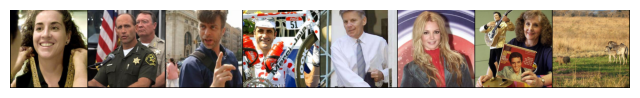

In [24]:
for i_batch, sample_batched in enumerate(train_dataloader):

    print(i_batch, sample_batched['image'].size(), sample_batched['num_faces'])

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_faces_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

In [25]:
# Setup training loop
def train_model (model, training_dataloader, testing_dataloader, num_epochs=10, learning_rate=0.001):
  model.to(device)
  # Setup optimizer and loss function
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  criterion = nn.MSELoss()
  training_losses = []
  testing_losses = []
  for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, sample_batched in enumerate(training_dataloader):
      if i % 10 == 0:
        print(f"Epoch {epoch + 1}, Batch {i + 1}")
      images = sample_batched['image']
      labels = sample_batched['num_faces'].float()
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      loss = criterion(outputs, labels)
      # Backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      # Track training loss
      running_loss += loss.item()
    # Track average training loss for the epoch
    training_losses.append(running_loss / len(training_dataloader))
    print(f"Epoch {epoch + 1}, Loss: {training_losses[-1]}")
    # Save model checkpoint
    torch.save(model.state_dict(), f"model_checkpoint_epoch_{epoch + 1}.pth")
    # Calculate validation loss
    model.eval()
    with torch.no_grad():
      testing_loss = 0.0
      for i, eval_batched in enumerate(testing_dataloader):
        images = eval_batched['image']
        labels = eval_batched['num_faces'].float()
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        testing_loss += loss.item()
      testing_losses.append(testing_loss / len(testing_dataloader))
      print(f"Validation Loss: {testing_losses[-1]}")

  return training_losses, testing_losses

In [26]:
train_model(baseline_model, train_dataloader, val_dataloader, num_epochs=5)
# TODO: need to repeat trials to obtain average performance

NameError: name 'baseline_model' is not defined

In [ ]:
configurations = [
  [],
  ['layer1', 'layer2', 'layer3', 'layer4'],
  ['layer1', 'layer2'],
  ['layer3', 'layer4'],
]
num_trials = 5
results = {}
for configuration in configurations:
  print(f"Configuration: {configuration}")
  for trial in range(num_trials):
    print(f"Trial: {trial + 1}")
    model = modify_resnet_with_lateral_inhibition(locations=configuration)
    training_losses, testing_losses = train_model(model, train_dataloader, val_dataloader, num_epochs=5)
    results[str(configuration)] = (training_losses, testing_losses)

In [ ]:
# Save results
import pickle
with open('results.pkl', 'wb') as f:
  pickle.dump(results, f)
  